# Episode 6: Contributing to Qiskit 1.0



Our overall goal here is to demonstrate how we can build on Qiskit 1.0 by way of example.

In particular, we will build a transpiler plugin for dynamic circuits.

Why? Though there are many transpilation passes, they've typically been developed with static circuits and unitary gates in mind. Dynamic circuits, which contain mid-circuit measurements and classical logic (see episode 5!), present an opportunity to build transpilation tools to optimize these as well.

Consider the `reset` operation. Perhaps the most basic example of an operation in a dynamic circuit,  a `reset` can be implemented as a projective measurement to 0 or 1, followed by a conditional X gate when the qubit is in the 1 state. They're required to prepare the qubits in the all-0 state before a new shot. In addition, they are often used in emerging quantum simulations of open systems or quantum neural networks, for instance.

While initially mapping the problem to quantum circuits and operators (step 1 of Qiskit Patterns), we might find that we have `reset` multiple times in a row. But this may not be desirable because `reset` takes more time and therefore results in additional decoherence of the other qubits.

So today, we'll build a transpiler plugin that merges sequential `reset` operations.

## Preamble

The default behavior of some transpilers does _not_ result in the merging of `reset` instructions.

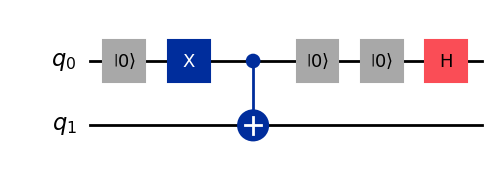

In [1]:
from qiskit import QuantumCircuit, transpile

qc = QuantumCircuit(2)
qc.reset(0)
qc.x(0)
qc.cx(0, 1)
qc.reset(0)
qc.reset(0)
qc.h(0)
qc.draw(output='mpl')

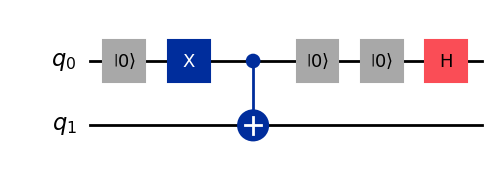

In [2]:
qc_basic_transpile = transpile(qc, optimization_level=3)
qc_basic_transpile.draw(output='mpl', style='iqp')

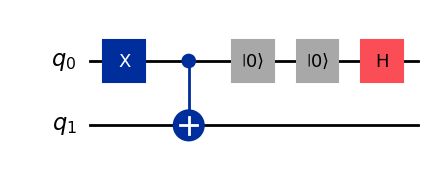

In [3]:
from qiskit.transpiler.passes.optimization.remove_reset_in_zero_state import RemoveResetInZeroState
from qiskit.converters import circuit_to_dag, dag_to_circuit

remove_reset = RemoveResetInZeroState()
remove_reset(qc).draw('mpl')

## Making a transpilation pass

We follow the documentation here: https://github.com/Qiskit/documentation/blob/kjs/transpiler-plugins/docs/transpile/transpiler-plugins.ipynb

Note that the double-reset is turned into just one.


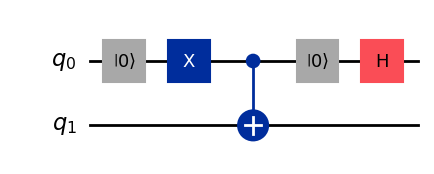

In [5]:
from dynacir.dynacir_passes import CollectResets

collect_resets = CollectResets()

circuit_with_less_resets = collect_resets(qc)
circuit_with_less_resets.draw(output='mpl')

## Testing our plugin

You must install the plugin found here: https://github.com/derek-wang-ibm/dynacir

To install, simply run `pip install dynacir` in your Terminal or the following in your notebook.

In [ ]:
!pip install git+https://github.com/derek-wang-ibm/dynacir.git

In [11]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
print(list_stage_plugins("optimization"))

['dynacir', 'default']


In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, optimization_method="dynacir"
)

qc_dynacir = pm.run(qc)
qc_dynacir.draw(output='mpl', style='iqp')